# Artificial Intelligence II
---

# Assignment 1: Business Case with Machine Learning


## Supervised Learning: Classification Algorithms 

### Lending Club Loan Default Prediction
---

## Table of Contents

1) Introduction
  
2) Data Loading and Initial Exploration

3) Data Cleaning
    - 3.1 Column Filtering — Removing Low-Value & Leaky Features
    - 3.2 Missing Values Analysis
    - 3.3 Handling Missing Values
    - 3.4 Imputing Remaining Numerical Features

4) Feature Engineering
    - 4.1 Date Processing
    - 4.2 Define Target Variable and Separate Open vs Closed Loans

5) Feature Selection
    - 5.1 Identifying Categorical Columns
    - 5.2 Categorical Encoding for Model Training
    - 5.3 Feature Selection
    - 5.4 Correlation Analysis of Numerical Features
    - 5.5 Final Numerical Feature Selection

6) Data Preprocessing

7) Model Development
    - 7.1 Initial Random Forest Model Training and Evaluation
    - 7.2 Feature Importance Analysis
    - 7.3 Handling Class Imbalance with SMOTE
    - 7.4 Retrain Random Forest After Balancing

8) Model Evaluation
    - 8.1 Train & Evaluate XGBoost Model After SMOTE (Clean Version)
    - 8.2 Visualizing Confusion Matrices
    - 8.3 Business Impact Analysis (Confusion Matrix Interpretation)
    - 8.4 Cost-Sensitive Threshold Optimization

9) Apply Model to Open Loans and Estimate Business Impact

---

## 1. Introduction

This project aims to predict loan defaults using historical loan data from Lending Club. By identifying patterns and risk factors associated with loan defaults, we can develop a model to help assess the creditworthiness of borrowers and optimize investment strategies.

---

## 2. Data Loading and Initial Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
#file_path = "Loan_Lending_Club_Sample_10000.xlsx"
file_path = "Loan_Lending_Club (USE THIS ONE).xlsx"  # Full dataset
df = pd.read_excel(file_path)

# Display first few rows
df.head()

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,120122535,12000,12000,12000.0,36 months,0.0797,375.88,A,A5,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N
1,1,119374887,32000,32000,32000.0,36 months,0.1199,1062.71,B,B5,...,2020-04-01,2020-06-01,2020-04-01,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
2,2,119321612,40000,40000,40000.0,60 months,0.1505,952.65,C,C4,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N
3,3,120122034,16000,16000,16000.0,36 months,0.0797,501.17,A,A5,...,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,N
4,4,118659541,33000,33000,33000.0,36 months,0.0721,1022.12,A,A3,...,2020-02-01,2020-04-01,2020-02-01,3.0,21.0,DELINQUENT,177.96231,10197.78,59.68,N


---

## 3. Data Cleaning

### 3.1 Column Filtering — Removing Low-Value & Leaky Features

To ensure high model performance and generalizability, we remove columns that:

- Have **low predictive value** (e.g., administrative fields)
- Are **only available post-loan decision** (e.g., repayments), which would lead to **data leakage**
- Contain **duplicate, high-cardinality, or joint application** information irrelevant to our current goal
- Are **edge-case specific** (e.g., hardship plans)

By eliminating such columns, we focus the model only on features known **at the time of loan issuance**, aligning with real-world predictive use.

A total of **`79` columns were dropped** using this filtering step.

In [2]:
# 1. Administrative/Operational Columns - Low predictive value for default prediction
admin_cols = ['id', 'url', 'pymnt_plan', 'initial_list_status', 'policy_code']

# 2. Post-Decision Information - Would cause data leakage
post_decision_cols = [
    'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d'
]

# 3. Secondary Applicant Data - Not relevant for this use case
secondary_applicant_cols = [
    'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint',
    'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line',
    'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc',
    'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts',
    'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med'
]

# 4. Hardship Program Data - Exceptional, not part of typical loan flows
hardship_cols = [
    'hardship_flag', 'debt_settlement_flag', 'hardship_type', 'hardship_reason',
    'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date',
    'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
    'hardship_loan_status', 'orig_projected_additional_accrued_interest',
    'hardship_payoff_balance_amount', 'hardship_last_payment_amount'
]

# 5. Highly Specific Credit Metrics
specific_credit_cols = [
    'mths_since_last_major_derog', 'tot_coll_amt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
    'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd',
    'num_tl_90g_dpd_24m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'chargeoff_within_12_mths', 'tax_liens'
]

# 6. High Cardinality Categorical Variables
high_cardinality_cols = ['emp_title', 'zip_code', 'title']

# 7. Duplicative Information
duplicative_cols = ['funded_amnt', 'funded_amnt_inv', 'last_credit_pull_d']

# 8. Other Low-Value Fields
other_low_value_cols = [
    'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'delinq_amnt',
    'tot_cur_bal', 'open_acc_6m', 'inq_fi', 'total_cu_tl'
]

# Combine all columns to drop
columns_to_drop = (
    admin_cols + post_decision_cols + secondary_applicant_cols + hardship_cols +
    specific_credit_cols + high_cardinality_cols + duplicative_cols + other_low_value_cols
)

# Drop columns from dataset
df_cleaned = df.drop(columns=columns_to_drop)

print(f"Total columns dropped: {len(columns_to_drop)}")

Total columns dropped: 79


In [3]:
# Drop default unnamed index column
df_cleaned = df_cleaned.drop(columns=['Unnamed: 0'], errors='ignore')


#### 3.2 Missing Value Analysis

To ensure data quality, we examine the extent of missing values across all columns. This helps guide appropriate imputation or removal strategies later on.

Steps:
- Count missing values per column
- Calculate percentage missing for better interpretability
- Sort and display only columns with missing data

> This step allows us to decide which columns to drop, impute, or engineer based on data completeness and business importance.

In [4]:
# Calculate the percentage of missing values per column
missing_values = df_cleaned.isnull().sum()
missing_percentage = (missing_values / len(df_cleaned)) * 100

# Create a DataFrame to display missing value statistics
missing_data = pd.DataFrame({
    "Column": df_cleaned.columns,
    "Missing Values": missing_values.values,
    "Percentage Missing": missing_percentage.values
})

# Filter to show only columns with missing values
missing_data = missing_data[missing_data["Missing Values"] > 0]

# Sort by percentage of missing values in descending order
missing_data = missing_data.sort_values(by="Percentage Missing", ascending=False)

# Display the missing values analysis
print("Missing Values Analysis:")
print(missing_data)

Missing Values Analysis:
                    Column  Missing Values  Percentage Missing
21  mths_since_last_record          893444           85.205541
20  mths_since_last_delinq          554582           52.889111
34                 il_util          409607           39.063205
32      mths_since_rcnt_il          317462           30.275564
38                all_util          290792           27.732113
33            total_bal_il          290612           27.714946
37              max_bal_bc          290612           27.714946
40            inq_last_12m          290612           27.714946
29             open_act_il          290612           27.714946
30             open_il_12m          290612           27.714946
31             open_il_24m          290612           27.714946
35             open_rv_12m          290612           27.714946
36             open_rv_24m          290612           27.714946
6               emp_length           77040            7.347114
44                 bc_util    

### 3.3 Handling Missing Values

To ensure robustness and consistency in modeling, we apply a tailored approach to handle missing data:

- **Dropped columns** with more than 25% missing values, as imputing them would introduce too much noise.
- **Filled missing values**:
  - `'emp_length'` (categorical): filled with `"Unknown"`
  - `'bc_open_to_buy'` & `'bc_util'` (numerical): filled using the **median** for robustness
- **Optional indicator columns** were created for selected features if missing values persisted post-imputation.

This strategy balances data retention with model interpretability and performance.

In [5]:
# Drop columns with >25% missing values
cols_to_drop = [
    'mths_since_last_record', 'mths_since_last_delinq', 'il_util', 'mths_since_rcnt_il',
    'all_util', 'total_bal_il', 'max_bal_bc', 'inq_last_12m', 'open_act_il',
    'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m'
]
df_cleaned = df_cleaned.drop(columns=cols_to_drop, errors='ignore')

# Handle specific missing values
if 'emp_length' in df_cleaned.columns:
    df_cleaned.loc[:, 'emp_length'] = df_cleaned['emp_length'].fillna("Unknown")

if 'bc_open_to_buy' in df_cleaned.columns:
    df_cleaned.loc[:, 'bc_open_to_buy'] = df_cleaned['bc_open_to_buy'].fillna(df_cleaned['bc_open_to_buy'].median())

if 'bc_util' in df_cleaned.columns:
    df_cleaned.loc[:, 'bc_util'] = df_cleaned['bc_util'].fillna(df_cleaned['bc_util'].median())

missing_cols = ['emp_length', 'bc_open_to_buy', 'bc_util']
for col in missing_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned.loc[:, f"{col}_missing"] = df_cleaned[col].isnull().astype(int)

# Display final missing value status
print("Final Missing Values Status:")
print(df_cleaned.isnull().sum().sort_values(ascending=False).head(10))

Final Missing Values Status:
dti                      1540
revol_util               1067
avg_cur_bal                62
loan_amnt                   0
num_bc_sats                 0
acc_open_past_24mths        0
bc_open_to_buy              0
bc_util                     0
mort_acc                    0
num_accts_ever_120_pd       0
dtype: int64


### 3.4 Impute Remaining Numerical Features

Some remaining numerical features had low levels of missing values. For these, we applied **median imputation** to preserve central tendency while reducing the influence of outliers:

- `'dti'`: Debt-to-Income Ratio
- `'revol_util'`: Revolving Line Utilization Rate
- `'avg_cur_bal'`: Average Current Balance

These features are critical for creditworthiness evaluation, so retaining them with robust imputation improves model performance and avoids unnecessary data loss.

In [6]:
# Fill missing values using median for numerical features
df_cleaned.loc[:, 'dti'] = df_cleaned['dti'].fillna(df_cleaned['dti'].median())
df_cleaned.loc[:, 'revol_util'] = df_cleaned['revol_util'].fillna(df_cleaned['revol_util'].median())
df_cleaned.loc[:, 'avg_cur_bal'] = df_cleaned['avg_cur_bal'].fillna(df_cleaned['avg_cur_bal'].median())

# Confirm missing values are handled
print(df_cleaned.isnull().sum().sort_values(ascending=False).head(10))

loan_amnt                0
last_fico_range_high     0
total_rev_hi_lim         0
acc_open_past_24mths     0
avg_cur_bal              0
bc_open_to_buy           0
bc_util                  0
mort_acc                 0
num_accts_ever_120_pd    0
num_actv_bc_tl           0
dtype: int64


In [7]:
df_cleaned.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_fico_range_high', 'last_fico_range_low',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_op_past_12m', 'pub_rec_bankruptcies',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object')

---

## 4) Feature Engineering

### 4.1 Date Processing
We transformed the loan issuance date (`issue_d`) into meaningful temporal features:

- `issue_year`: captures macro trends (e.g., post-2008 recession recovery)
- `issue_month`: captures seasonality (e.g., Q4 lending peaks)

The original `issue_d` column was removed afterward to avoid redundant information and maintain model simplicity.

> These engineered features can help capture time-based patterns in default behavior.

In [8]:
# Convert 'issue_d' to datetime
df_cleaned['issue_d'] = pd.to_datetime(df_cleaned['issue_d'])

# Extract year and month components
df_cleaned['issue_year'] = df_cleaned['issue_d'].dt.year
df_cleaned['issue_month'] = df_cleaned['issue_d'].dt.month

# Drop the original datetime column
df_cleaned.drop(columns=['issue_d'], inplace=True)

### 4.2 Define Target Variable and Separate Open vs Closed Loans

In this binary classification problem, we aim to predict whether a loan will be **good** (repaid) or **bad** (defaulted).

- Good loan → `Fully Paid` → `loan_status_binary = 1`
- Bad loan → `Charged Off` or `Default` → `loan_status_binary = 0`

We:
- Filtered the dataset into **closed loans** (for model training) and **open loans** (for later prediction)
- Created a binary target variable for closed loans

> We'll use the model trained on closed loans to predict outcomes for open loans and assess the business impact.

In [9]:
# Define closed and open loan statuses
closed_statuses = ['Fully Paid', 'Charged Off', 'Default']
open_statuses = ['Current', 'In Grace Period', 'Late 16-30 days', 'Late 31-120 days']

# Create binary target for closed loans
df_closed = df_cleaned[df_cleaned['loan_status'].isin(closed_statuses)].copy()
df_closed['loan_status_binary'] = df_closed['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Save open loans separately for future prediction
df_open = df_cleaned[df_cleaned['loan_status'].isin(open_statuses)].copy()

# Confirm shapes
print("Closed loans shape:", df_closed.shape)
print("Open loans shape:", df_open.shape)

df_closed = df_closed.drop(columns=['loan_status'])

Closed loans shape: (648719, 51)
Open loans shape: (390979, 50)


---

## 5) Feature Selection

### 5.1 Identifying Categorical Columns

In [10]:
df_cleaned.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'last_fico_range_high', 'last_fico_range_low',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_op_past_12m', 'pub_rec_bankruptcies',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'issue_year', 'issue_month'],
      dtype='object')

In [11]:
# Identify categorical variables in df_closed
categorical_vars = df_closed.select_dtypes(include='object').columns.tolist()

# Print categorical variables
print("Categorical Variables in df_closed:", categorical_vars)

Categorical Variables in df_closed: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']


### 5.2 Categorical Encoding for Model Training

Since machine learning models require numerical inputs, we encode categorical features using **Label Encoding**.

Steps:
1️⃣ **Identified categorical variables** in `df_closed`.
2️⃣ **Applied `LabelEncoder`** to convert categorical values into integers.
3️⃣ **Stored encoders** (`le_dict`) for potential inverse transformation later.

> If needed, `le_dict[col].inverse_transform()` can be used to recover original labels from predictions.

In [12]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_closed.copy()

# Identify categorical variables in df_closed
categorical_vars = df_closed.select_dtypes(include='object').columns.tolist()

# Dictionary to store LabelEncoders for future inverse transformations
le_dict = {}

# Apply Label Encoding
for col in categorical_vars:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    le_dict[col] = le  # Store encoder for later use

# Confirm Encoding
print("Categorical Encoding Completed. Sample Data:")
print(df_encoded.head())

Categorical Encoding Completed. Sample Data:
    loan_amnt  term  int_rate  installment  grade  sub_grade  emp_length  \
0       12000     0    0.0797       375.88      0          4           1   
6       10000     0    0.0944       320.05      1          5           3   
7        8000     0    0.1602       281.34      2         14          10   
8       12800     0    0.1359       434.93      2         11           5   
12      15000     0    0.1359       509.69      2         11           4   

    home_ownership  annual_inc  verification_status  ...  num_sats  \
0                3     42000.0                    1  ...         9   
6                1     55000.0                    0  ...         7   
7                1    120000.0                    0  ...         8   
8                4     90000.0                    0  ...         9   
12               1    180000.0                    1  ...        24   

    num_tl_op_past_12m  pub_rec_bankruptcies  tot_hi_cred_lim  \
0           

### 5.3 Feature Selection

To evaluate the importance of categorical features in predicting loan status, we compute **Mutual Information (MI) Scores**.

**Why MI?**  
- Measures the dependency between a feature and the target variable.
- Higher MI scores → Feature carries **more predictive power**.

**Steps:**
- Extracted categorical features from `df_encoded` (our transformed dataset).  
- Applied `mutual_info_classif` to compute MI scores for each categorical feature.  
- Sorted features by importance for better feature selection insights.

> Features with **higher MI scores** will be prioritized in modeling.

In [13]:
from sklearn.feature_selection import mutual_info_classif

# Extract encoded categorical variables from df_encoded
X_cat = df_encoded[categorical_vars]

# Define target variable
y = df_encoded['loan_status_binary']

# Compute mutual information scores
mi_scores = mutual_info_classif(X_cat, y, discrete_features=True)

# Create DataFrame to store MI scores
mi_df = pd.DataFrame({'Feature': categorical_vars, 'MI Score': mi_scores})

# Sort by importance
mi_df.sort_values(by='MI Score', ascending=False, inplace=True)

# Display results
print("Mutual Information Scores for Categorical Features:")
print(mi_df)

Mutual Information Scores for Categorical Features:
               Feature  MI Score
2            sub_grade  0.033174
1                grade  0.031145
0                 term  0.012136
5  verification_status  0.003652
4       home_ownership  0.003036
3           emp_length  0.001727
7           addr_state  0.001617
6              purpose  0.001411


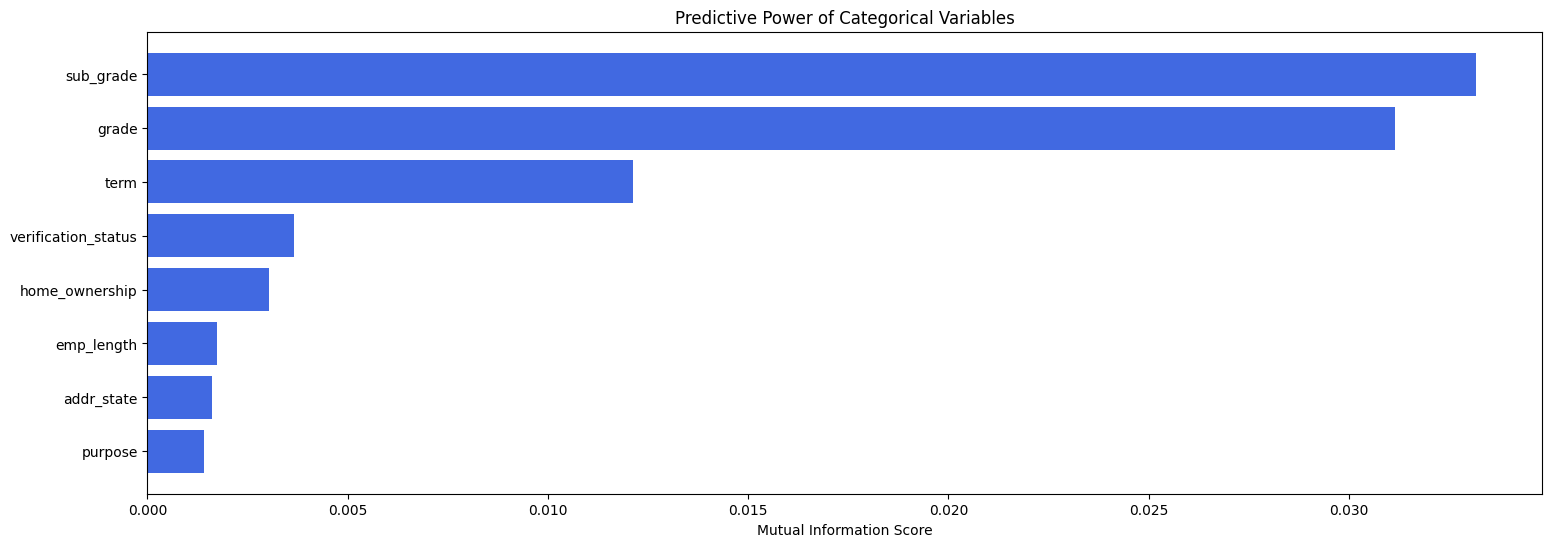

In [14]:
import matplotlib.pyplot as plt

# Plot Mutual Information Scores
plt.figure(figsize=(18, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='royalblue')
plt.xlabel('Mutual Information Score')
plt.title('Predictive Power of Categorical Variables')
plt.gca().invert_yaxis()  # Invert to show highest scores on top
plt.show()

#### Selecting Categorical Features with High Predictive Power

To refine our feature set, we **keep only categorical variables** with a **Mutual Information Score > 0.01**.

- **Why?**  
  - Helps remove weak features that add noise.
  - Improves model efficiency without losing predictive power.

> **Selected Features:** These categorical variables will be used in the final model training.

In [15]:
# Select categorical variables with MI Score > 0.01
selected_categorical_vars = mi_df[mi_df['MI Score'] > 0.01]['Feature'].tolist()

# Print selected categorical features
print("Selected Categorical Variables:", selected_categorical_vars)

Selected Categorical Variables: ['sub_grade', 'grade', 'term']


#### Encoding Loan Grade & Sub-Grade

Loan grades (`grade`) and sub-grades (`sub_grade`) are key risk indicators. We apply **Label Encoding** to transform them into numerical values.

**Steps:**
- Applied `LabelEncoder()` to **convert categorical grades into numerical values**.  
- Computed the **correlation** between `grade_encoded` and `sub_grade_encoded`.

> **Why check correlation?**  
> If `grade` and `sub_grade` are highly correlated, we may only need one in the final model.

In [16]:
from sklearn.preprocessing import LabelEncoder

# Ensure 'grade' and 'sub_grade' exist in df_encoded
if 'grade' in df_encoded.columns and 'sub_grade' in df_encoded.columns:
    le = LabelEncoder()
    
    # Encode 'grade' and 'sub_grade'
    df_encoded['grade_encoded'] = le.fit_transform(df_encoded['grade'])
    df_encoded['sub_grade_encoded'] = le.fit_transform(df_encoded['sub_grade'])

    # Check correlation
    correlation = df_encoded[['grade_encoded', 'sub_grade_encoded']].corr()
    print("Correlation between 'grade_encoded' and 'sub_grade_encoded':")
    print(correlation)

Correlation between 'grade_encoded' and 'sub_grade_encoded':
                   grade_encoded  sub_grade_encoded
grade_encoded           1.000000           0.975381
sub_grade_encoded       0.975381           1.000000


#### Dropping Redundant & Unused Features

To improve model efficiency and avoid multicollinearity, we remove:
- **`grade`** → Kept only `sub_grade_encoded` since it's more granular.
- **`last_fico_range_high` & `last_fico_range_low`** → Potential data leakage.

> This step ensures that the dataset remains **optimized for modeling**.


In [17]:
# Drop redundant and unnecessary columns from df_encoded
df_encoded.drop(columns=['grade'], inplace=True)  # Remove redundant 'grade' since 'sub_grade_encoded' exists
df_encoded.drop(columns=['last_fico_range_high'], inplace=True, errors='ignore')  # Remove unused credit score feature
df_encoded.drop(columns=['last_fico_range_low'], inplace=True, errors='ignore')  # Remove lower FICO range feature

# Confirm column removal
print("Updated columns in df_encoded:", df_encoded.columns)

Updated columns in df_encoded: Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'issue_year', 'issue_month', 'loan_status_binary', 'grade_encoded',
       'sub_grade_encoded'],
      dtype='object')


#### Selecting Potential Categorical Variables

Based on **Mutual Information Scores (MI)** and **business relevance**, we select the following categorical variables:

- **Strong predictors**: `'sub_grade_encoded'`, `'term'`
- **Creditworthiness indicators**: `'verification_status'`, `'home_ownership'`, `'emp_length'`
- **Intent & location-based risk**: `'purpose'`, `'addr_state'`

These features will undergo **encoding** before model training.

In [18]:
# Define categorical variables for modeling (selected based on MI scores)
categorical_vars = [
    'sub_grade', 'term',   # Strong MI predictors
    'verification_status', 'home_ownership', 'emp_length',  # Creditworthiness indicators
    'purpose', 'addr_state'  # Borrower intent & location-based risk
]

# Confirm selected categorical variables
print("Potential categorical variables for encoding & modeling:", categorical_vars)

Potential categorical variables for encoding & modeling: ['sub_grade', 'term', 'verification_status', 'home_ownership', 'emp_length', 'purpose', 'addr_state']


In [19]:
# Convert 'term' column to numeric (extracting only the number of months)
df_encoded['term'] = df_encoded['term'].astype(str).str.extract(r'(\d+)').astype(int)

### 5.4 Correlation Analysis of Numerical Features

To identify **multicollinearity** and **feature interactions**, we compute the **correlation matrix** of all numerical features.

- High correlation between features (e.g., > 0.75) may require removing one to avoid redundancy.
- A heatmap helps visually identify strong positive/negative relationships.

> ⚠️ Important: This analysis is based on `df_encoded`, our cleaned and feature-engineered dataset for model training.

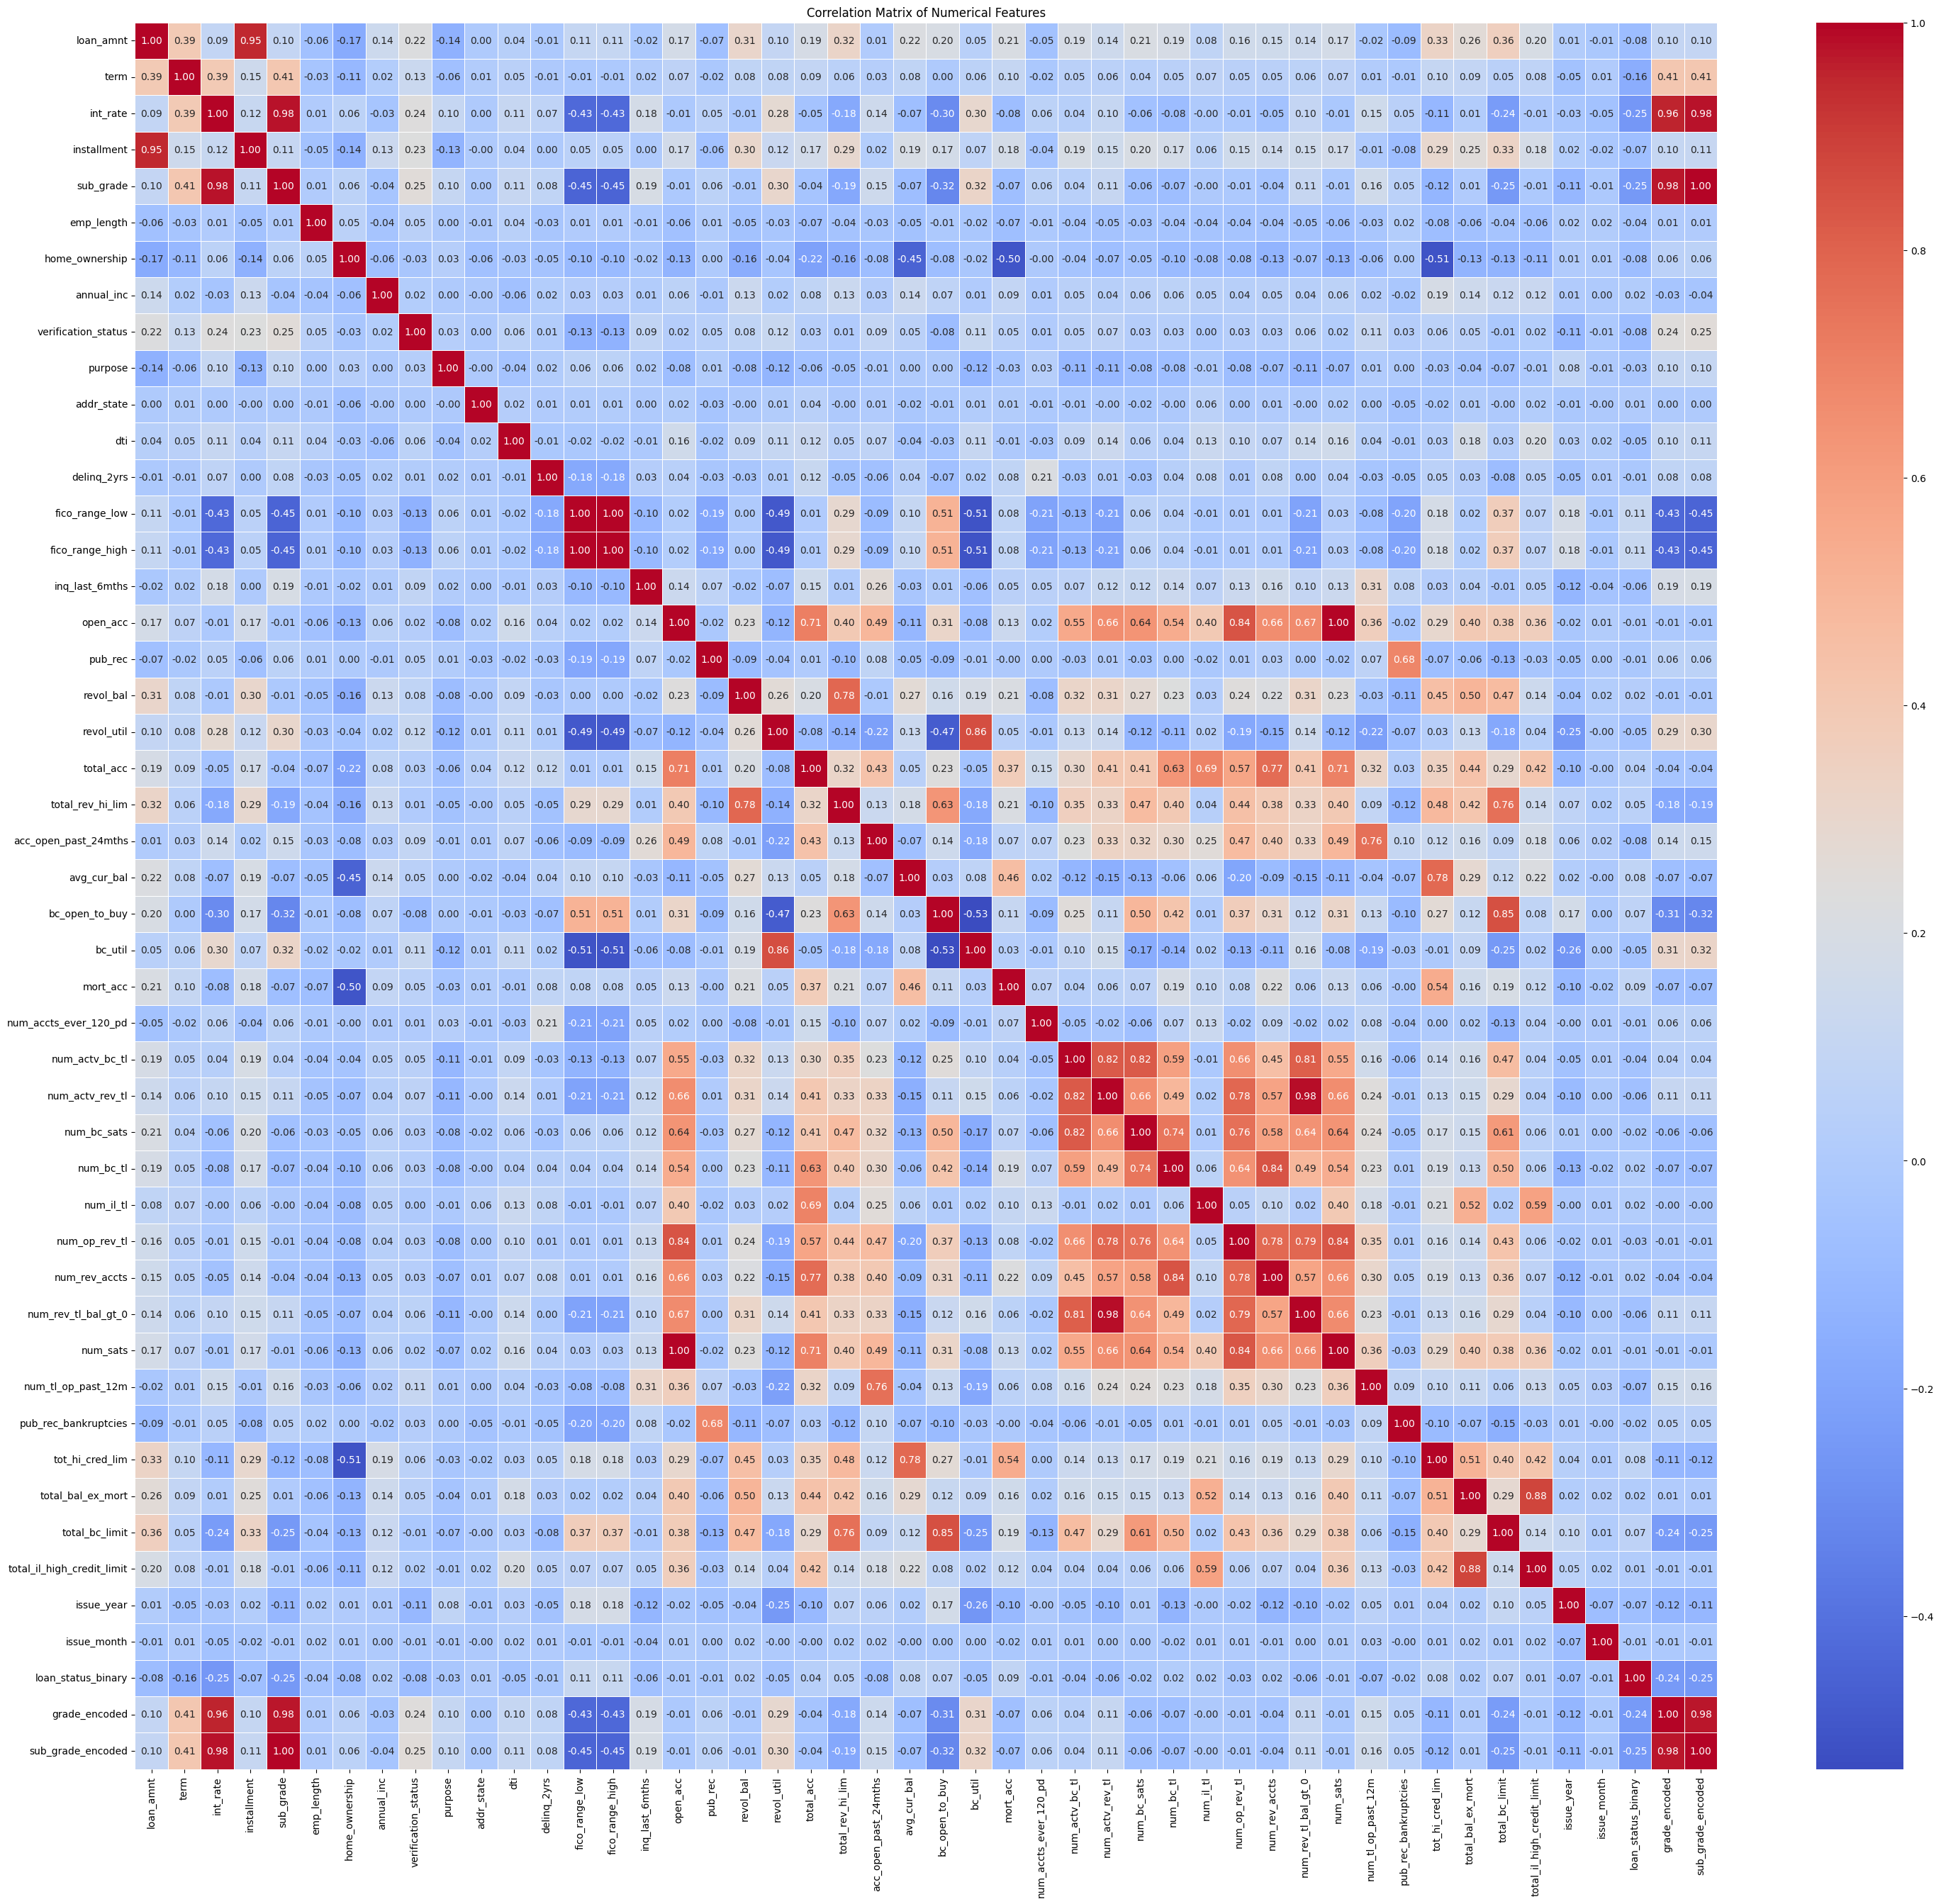

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns from df_encoded
numerical_df = df_encoded.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(36, 32))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

#### Removing Highly Correlated Features

To reduce **multicollinearity** and avoid redundant predictors, we:
1. Computed the correlation matrix for numerical features.
2. Identified feature pairs with correlation above a chosen threshold (`> 0.75`).
3. Dropped one feature from each highly correlated pair.

> This step improves model interpretability and stability by avoiding collinear features.

In [21]:
import numpy as np
import pandas as pd

# Set correlation threshold
correlation_threshold = 0.75

# Compute correlation matrix for numerical features in df_encoded
corr_matrix = df_encoded.select_dtypes(include=['number']).corr()

# Extract upper triangle to avoid duplicate checks
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated features
high_corr_features = [col for col in upper_triangle.columns if any(upper_triangle[col] > correlation_threshold)]

# Check if 'sub_grade_encoded' is in high_corr_features and remove 'int_rate' instead
if 'sub_grade_encoded' in high_corr_features:
    if 'int_rate' in high_corr_features:
        high_corr_features.remove('int_rate')

print("Highly correlated features to drop:", high_corr_features)

# Drop them from df_encoded
df_encoded.drop(columns=high_corr_features, inplace=True)

Highly correlated features to drop: ['installment', 'sub_grade', 'fico_range_high', 'total_rev_hi_lim', 'bc_util', 'num_actv_rev_tl', 'num_bc_sats', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bc_limit', 'total_il_high_credit_limit', 'grade_encoded', 'sub_grade_encoded']


In [22]:
from sklearn.preprocessing import LabelEncoder

# Check if `sub_grade` exists in df_cleaned
if 'sub_grade' in df_cleaned.columns:
    # Encode `sub_grade` from `df_cleaned` to create `sub_grade_encoded`
    le = LabelEncoder()
    df_cleaned['sub_grade_encoded'] = le.fit_transform(df_cleaned['sub_grade'])

# Now, add `sub_grade_encoded` from df_cleaned to df_encoded
df_encoded['sub_grade_encoded'] = df_cleaned['sub_grade_encoded']

# Remove `int_rate` from df_encoded if it exists
if 'int_rate' in df_encoded.columns:
    df_encoded.drop(columns=['int_rate'], inplace=True)

# Check the result
print("Columns in df_encoded after adjustment:")
print(df_encoded.columns)

Columns in df_encoded after adjustment:
Index(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'mort_acc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
       'pub_rec_bankruptcies', 'total_bal_ex_mort', 'issue_year',
       'issue_month', 'loan_status_binary', 'sub_grade_encoded'],
      dtype='object')


#### Correlation Matrix (After Feature Reduction)

To verify the effectiveness of feature reduction, we re-plot the **correlation matrix** using `df_encoded`, after removing highly correlated features.

- This ensures no pairs of features remain with excessively high linear correlation.
- Helps confirm that the dataset is now suitable for modeling without multicollinearity issues.

> A cleaner correlation matrix = more stable and interpretable models.

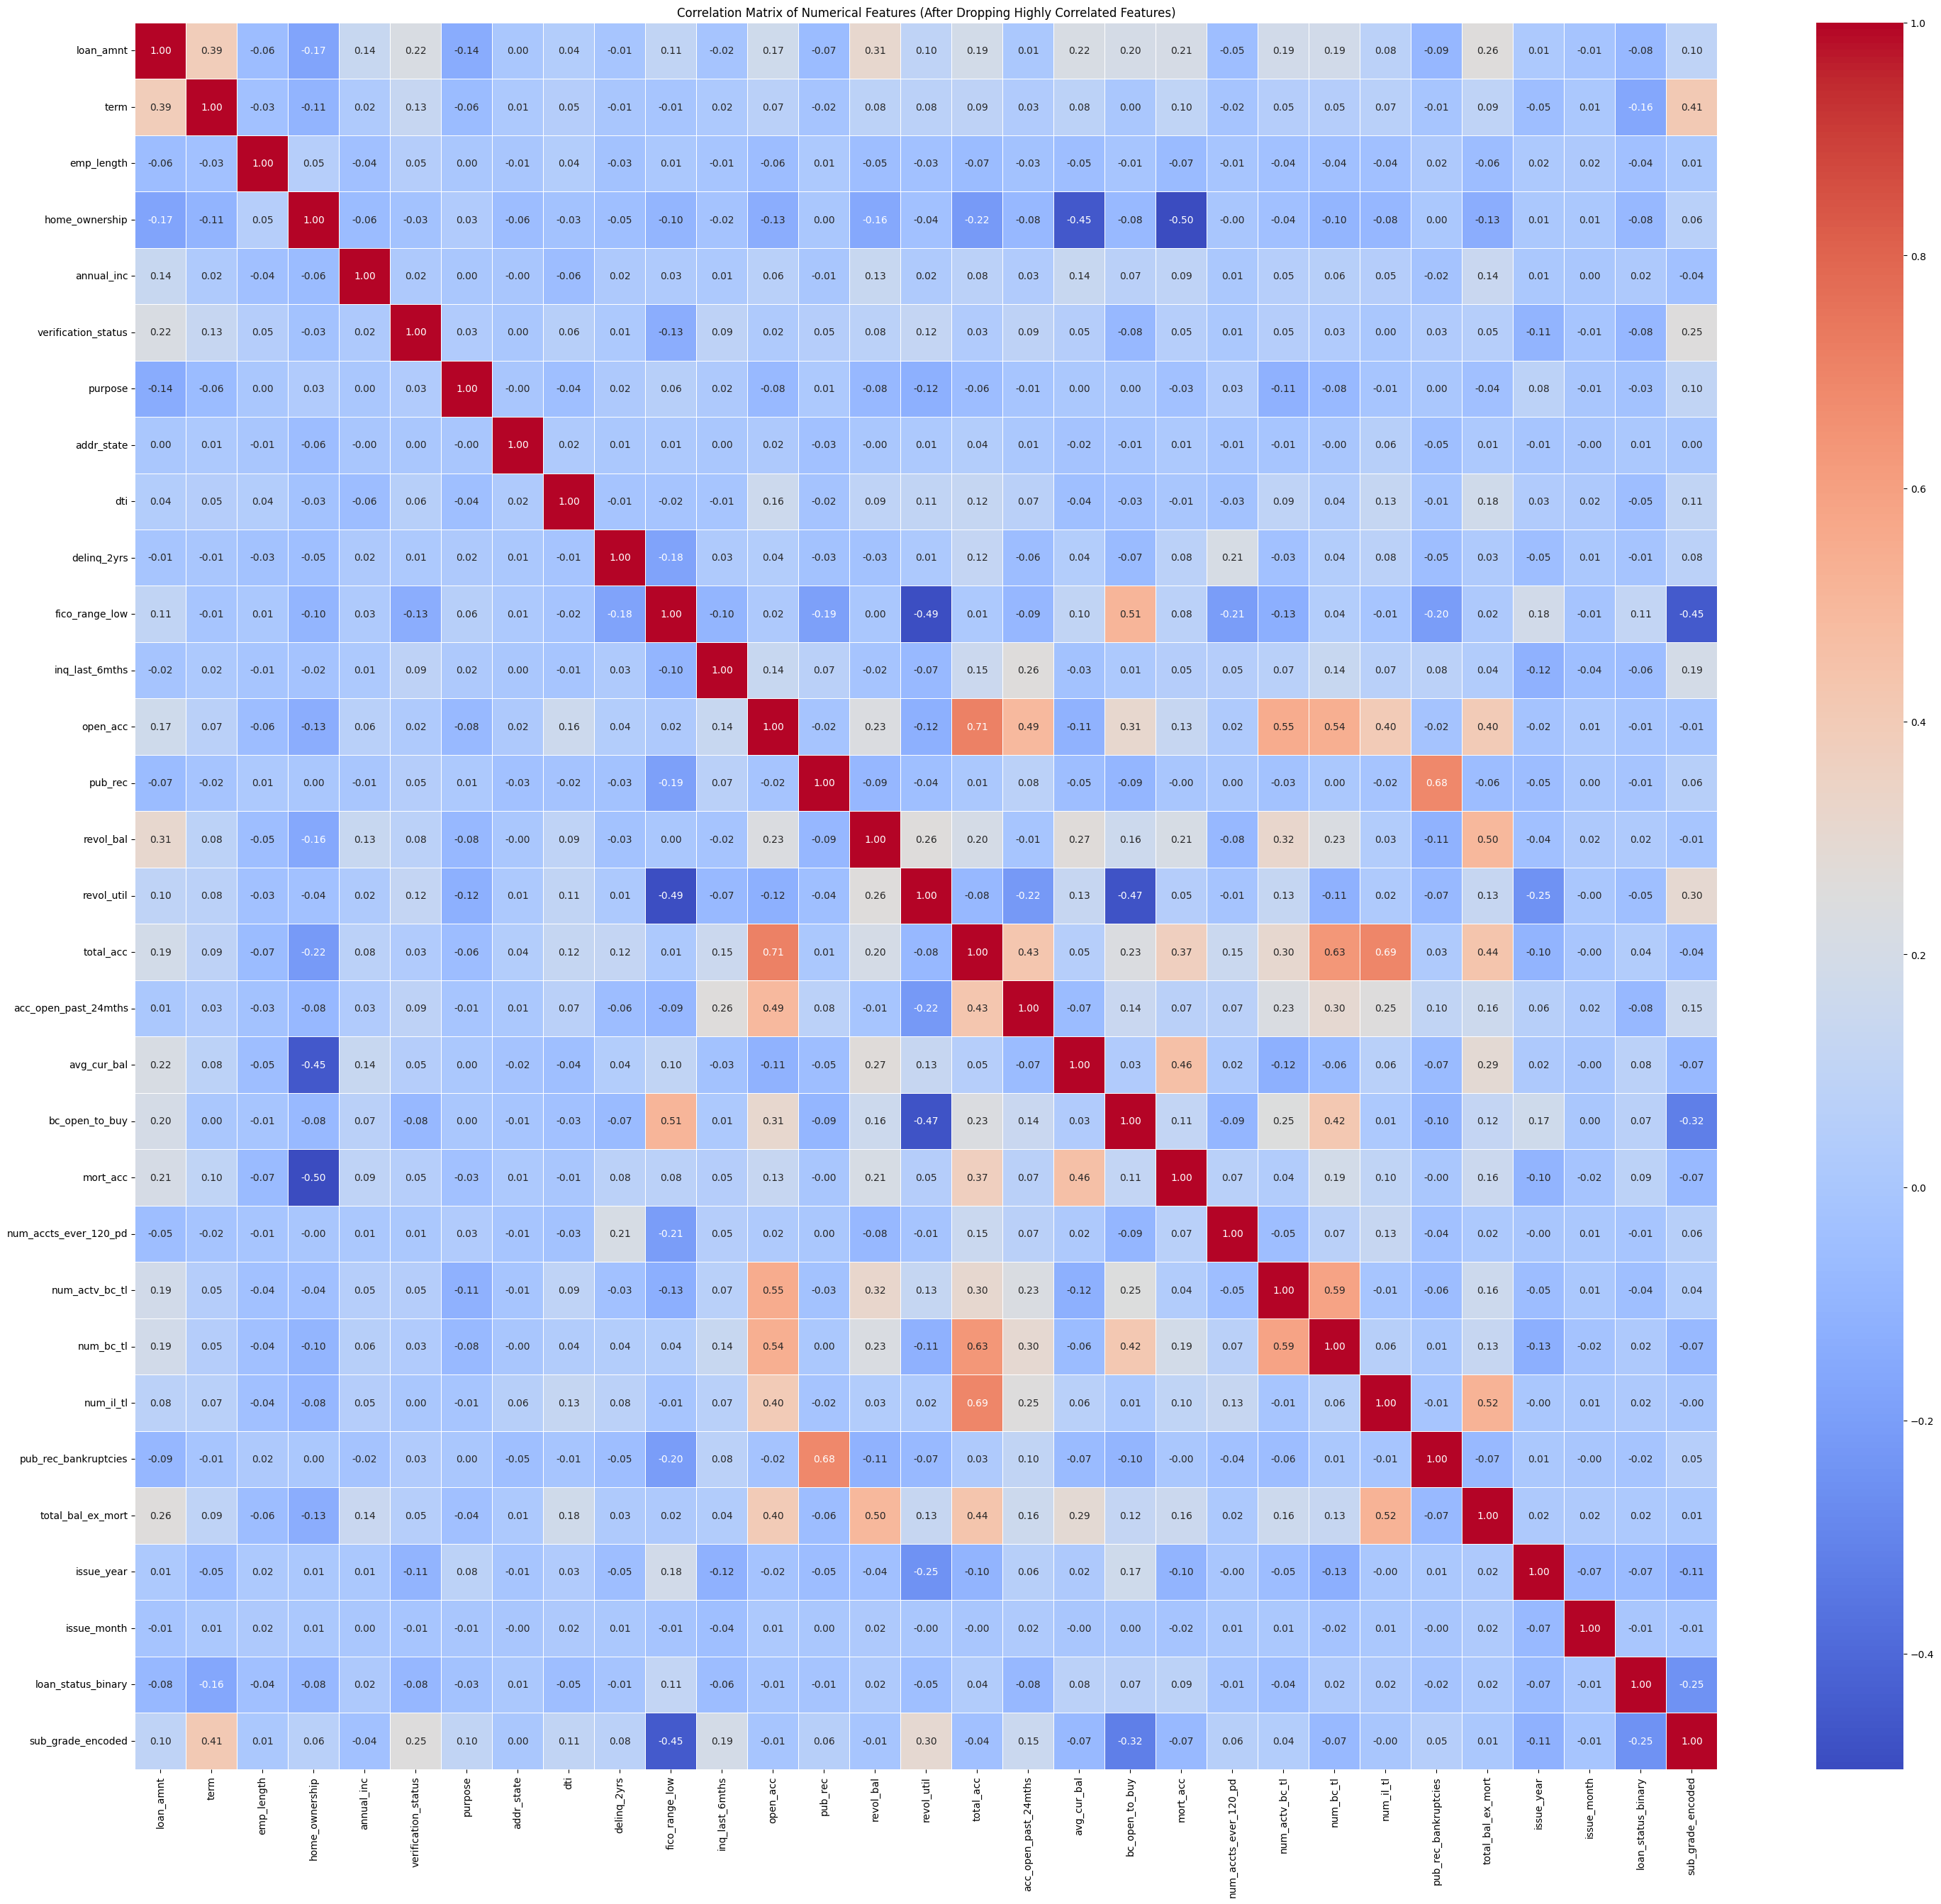

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns from df_encoded
numerical_df = df_encoded.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numerical_df.corr()

# Plot heatmap
plt.figure(figsize=(36, 32))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features (After Dropping Highly Correlated Features)")
plt.show()

### 5.5 Final Numerical Feature Selection

We finalize the list of **numerical variables** by excluding:
- The **target variable**: `loan_status_binary`
- Potentially **redundant features**: `last_fico_range_high`, `last_fico_range_low`

This ensures that only relevant, independent numerical features are used during model training.

In [24]:
from pprint import pprint

# Recompute numerical_df from df_encoded
numerical_df = df_encoded.select_dtypes(include=['number'])

# Exclude target and specific FICO score columns (even if already dropped)
excluded_cols = ['loan_status_binary', 'last_fico_range_high', 'last_fico_range_low']
numerical_vars = [col for col in numerical_df.columns if col not in excluded_cols]

# Print final results
print("Final numerical features selected:")
pprint(numerical_vars)

print("\nFinal categorical features selected:")
pprint(categorical_vars)

print("\nColumns in df_encoded:")
pprint(df_encoded.columns.tolist())

Final numerical features selected:
['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'mort_acc',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_bc_tl',
 'num_il_tl',
 'pub_rec_bankruptcies',
 'total_bal_ex_mort',
 'issue_year',
 'issue_month',
 'sub_grade_encoded']

Final categorical features selected:
['sub_grade',
 'term',
 'verification_status',
 'home_ownership',
 'emp_length',
 'purpose',
 'addr_state']

Columns in df_encoded:
['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'acc_open_past_24mths

#### Feature Engineering – Credit History Length

We transform the `earliest_cr_line` (first credit line date) into a **numeric feature** representing the **number of years since the borrower’s first credit account**.

- Converted the string to datetime.
- Subtracted the year to compute credit history length.
- Dropped the original date column to keep the dataset clean.

> This feature can be important as longer credit history may correlate with lower default risk.

In [25]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Convert `earliest_cr_line` to datetime format
df_encoded['earliest_cr_line'] = pd.to_datetime(df_encoded['earliest_cr_line'], errors='coerce')

# Calculate years since the first credit line
current_year = datetime.today().year
df_encoded['earliest_cr_line_years'] = current_year - df_encoded['earliest_cr_line'].dt.year

# Drop the original `earliest_cr_line` column
df_encoded.drop(columns=['earliest_cr_line'], inplace=True)

# Confirm the new feature
print("Sample of 'earliest_cr_line_years':")
print(df_encoded['earliest_cr_line_years'].head())

Sample of 'earliest_cr_line_years':
0     29
6     20
7     31
8     37
12    49
Name: earliest_cr_line_years, dtype: int32


---

## 6) Data Preprocessing

- Step 1) Encoding Categorical Variables
- Step 2) Scaling Numerical Variables
- Step 3) Train-Test Split

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split


categorical_vars = [
    'term', 'verification_status', 'home_ownership', 'emp_length',
    'purpose', 'addr_state'
]

# Apply Label Encoding for selected categorical features
le = LabelEncoder()
for col in categorical_vars:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


numerical_vars = [
    'loan_amnt', 'term', 'sub_grade_encoded', 'annual_inc', 'dti', 'delinq_2yrs', 
    'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 
    'revol_util', 'total_acc', 'acc_open_past_24mths', 
    'avg_cur_bal', 'bc_open_to_buy', 'mort_acc', 'num_accts_ever_120_pd', 
    'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'pub_rec_bankruptcies', 
    'total_bal_ex_mort', 'issue_year', 'issue_month', 'earliest_cr_line_years'
]

# Standardize numerical features
scaler = StandardScaler()
df_encoded[numerical_vars] = scaler.fit_transform(df_encoded[numerical_vars])


# Define features and target
X = df_encoded.drop(columns=['loan_status_binary'])
y = df_encoded['loan_status_binary']

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm shapes
print("Preprocessing Completed")
print(f"Train Set Shape: {X_train.shape}")
print(f"Test Set Shape: {X_test.shape}")

Preprocessing Completed
Train Set Shape: (518975, 31)
Test Set Shape: (129744, 31)


---

## 7) Model Development

### 7.1 Initial Random Forest Model Training and Evaluation

We trained a **Random Forest Classifier** using the selected and preprocessed features from `df_encoded`.

- Model Type: `RandomForestClassifier(n_estimators=100, random_state=42)`
- Training on: `X_train`, `y_train`
- Evaluation on: `X_test`, `y_test`

**Metrics:**
- **Accuracy**: Measures overall correctness
- **Precision, Recall, F1-Score**: Provide detailed insight into classification quality for each class (good vs. bad loans)

> This baseline model serves as a benchmark before tuning or exploring other algorithms.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Random Forest Classifier Performance:
Accuracy: 0.7913352447897398

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.09      0.16     27575
           1       0.80      0.98      0.88    102169

    accuracy                           0.79    129744
   macro avg       0.68      0.54      0.52    129744
weighted avg       0.75      0.79      0.73    129744



### 7.2 Feature Importance Analysis

After training the Random Forest model, we analyzed which features contributed the most to the prediction.

**Steps:**
- Extracted feature importance scores from the model.
- Sorted features by descending importance.
- Visualized the **Top 15 most influential features**.

> Understanding feature importance helps in interpreting the model and aligning decisions with business logic.

We also printed the **class distribution** in the training set to ensure awareness of any class imbalance.

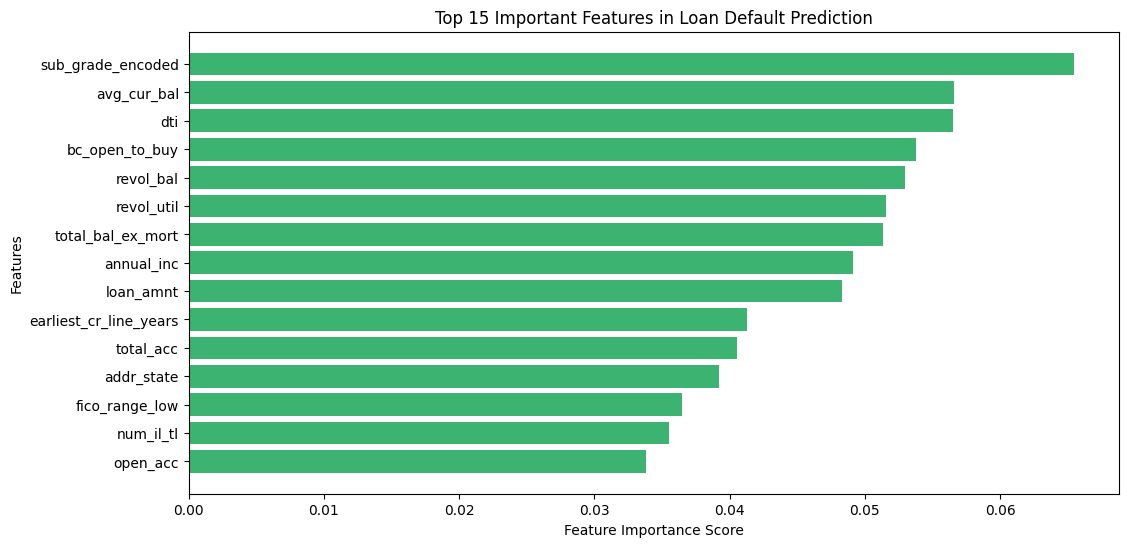

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance scores from the trained Random Forest model
feature_importance = rf_model.feature_importances_

# Sort features by importance (descending)
sorted_idx = np.argsort(feature_importance)[::-1]

# Plot top 15 most important features
plt.figure(figsize=(12, 6))
plt.barh(X.columns[sorted_idx][:15], feature_importance[sorted_idx][:15], color='mediumseagreen')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 15 Important Features in Loan Default Prediction")
plt.gca().invert_yaxis()
plt.show()

In [29]:
# Display class distribution in the training set
print("Class Distribution in y_train:")
print(y_train.value_counts(normalize=True))

Class Distribution in y_train:
loan_status_binary
1    0.787464
0    0.212536
Name: proportion, dtype: float64


### 7.3 Handling Class Imbalance with SMOTE

To address class imbalance in the training set, we apply **SMOTE** (Synthetic Minority Oversampling Technique):

- SMOTE generates synthetic examples for the minority class.
- Helps improve model performance on underrepresented outcomes (e.g., loan defaults).

> **SMOTE is applied only on the training set** to prevent data leakage.

**Balanced Class Distribution:**  
We confirm that the classes are now equally represented in `y_train_balanced`.

In [30]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Balanced Class Distribution After SMOTE:")
print(y_train_balanced.value_counts(normalize=True))

Balanced Class Distribution After SMOTE:
loan_status_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


### 7.4 Retrain Random Forest After Balancing

We retrain the **Random Forest model** on the SMOTE-balanced training dataset:

- **Model**: `RandomForestClassifier(n_estimators=100)`
- **Training data**: `X_train_balanced`, `y_train_balanced`
- **Evaluation**: Performed on the original test set (`X_test`, `y_test`)

> This allows us to measure the generalization of the balanced model without leaking synthetic data into evaluation.

Metrics like **Precision**, **Recall**, and **F1-score** are critical for assessing improvement after balancing.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest on SMOTE-balanced training data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions on the original test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance on test set
print("Random Forest Results After SMOTE Balancing:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Results After SMOTE Balancing:
Accuracy: 0.7867184609692934

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.17      0.25     27575
           1       0.81      0.95      0.88    102169

    accuracy                           0.79    129744
   macro avg       0.65      0.56      0.56    129744
weighted avg       0.74      0.79      0.74    129744



---

## 8) Model Evaluation

### 8.1 Train & Evaluate XGBoost Model After SMOTE (Clean Version)

We train an **XGBoost Classifier** on the SMOTE-balanced dataset.

- Removed deprecated `use_label_encoder=False` parameter.
- Let XGBoost handle label encoding internally as per latest versions.
- Model still uses `n_estimators=100` and `learning_rate=0.1`.

> Always keep XGBoost usage updated to avoid deprecated parameters and warnings.

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost without deprecated parameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on original test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("XGBoost Results After SMOTE Balancing:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Results After SMOTE Balancing:
Accuracy: 0.7909807004562831

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.14      0.22     27575
           1       0.81      0.97      0.88    102169

    accuracy                           0.79    129744
   macro avg       0.67      0.55      0.55    129744
weighted avg       0.75      0.79      0.74    129744



### 8.2 Visualizing Confusion Matrices

To better understand model performance, especially in terms of **False Positives (FP)** and **False Negatives (FN)**, we plot **confusion matrices** for:

- Random Forest
- XGBoost

**Axes:**
- X-axis: Predicted values  
- Y-axis: Actual values

> Helps visualize how well each model distinguishes between good (0) and bad (1) loans.

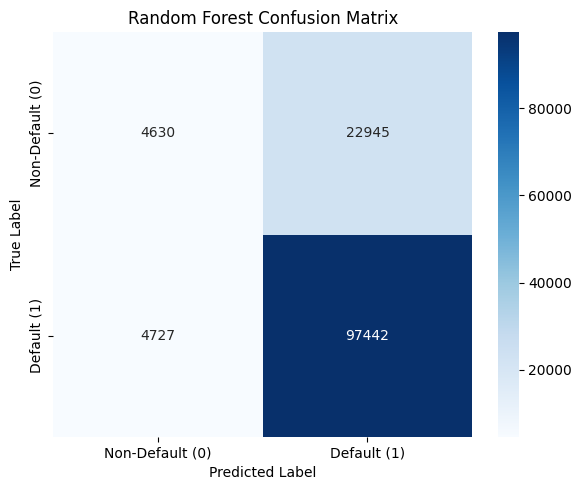

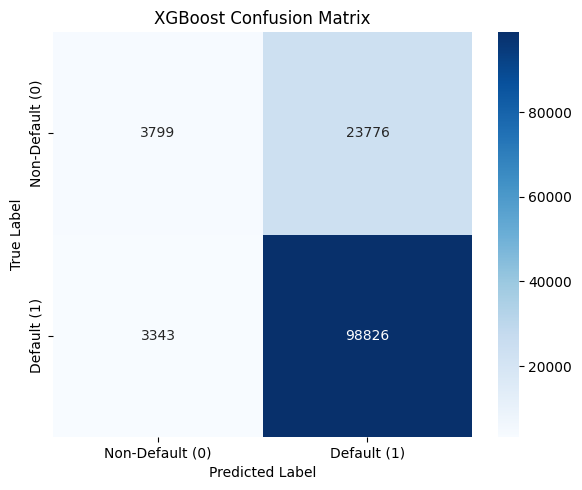

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define reusable function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Non-Default (0)", "Default (1)"],
                yticklabels=["Non-Default (0)", "Default (1)"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot for both models
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

### 8.3 Business Impact Analysis (Confusion Matrix Interpretation)

We interpret the confusion matrix of both models in terms of **real-world financial impact**:

- **True Positives (TP)**: Correctly flagged risky borrowers – avoided default losses.
- **False Positives (FP)**: Denied credit to good borrowers – lost revenue opportunity.
- **False Negatives (FN)**: Approved bad loans – incurred financial losses.
- **True Negatives (TN)**: Approved good loans – stable profit source.

> This step connects ML predictions to Lending Club’s actual risk-return tradeoff.

In [34]:
from sklearn.metrics import confusion_matrix

# Extract confusion matrix values for both models
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_test, y_pred_rf).ravel()
tn_xgb, fp_xgb, fn_xgb, tp_xgb = confusion_matrix(y_test, y_pred_xgb).ravel()

# Business impact of prediction outcomes
print("Business Impact Analysis – Random Forest")
print(f"True Positives (TP): {tp_rf} → Correctly identified defaulters")
print(f"False Positives (FP): {fp_rf} → Lost profitable customers")
print(f"False Negatives (FN): {fn_rf} → Approved loans that defaulted")
print(f"True Negatives (TN): {tn_rf} → Correctly identified safe borrowers")

print("\nBusiness Impact Analysis – XGBoost")
print(f"True Positives (TP): {tp_xgb} → Correctly identified defaulters")
print(f"False Positives (FP): {fp_xgb} → Lost profitable customers")
print(f"False Negatives (FN): {fn_xgb} → Approved loans that defaulted")
print(f"True Negatives (TN): {tn_xgb} → Correctly identified safe borrowers")

Business Impact Analysis – Random Forest
True Positives (TP): 97442 → Correctly identified defaulters
False Positives (FP): 22945 → Lost profitable customers
False Negatives (FN): 4727 → Approved loans that defaulted
True Negatives (TN): 4630 → Correctly identified safe borrowers

Business Impact Analysis – XGBoost
True Positives (TP): 98826 → Correctly identified defaulters
False Positives (FP): 23776 → Lost profitable customers
False Negatives (FN): 3343 → Approved loans that defaulted
True Negatives (TN): 3799 → Correctly identified safe borrowers


### 8.4 Cost-Sensitive Threshold Optimization

To balance the **cost of false positives (FP)** and **false negatives (FN)**, we explore different decision thresholds. The goal is to minimize the total business cost:

- **FP Cost**: Losing a profitable customer (missed revenue).
- **FN Cost**: Approving a loan that defaults.

### Process:
- **Predicted probabilities** are extracted using `xgb_model.predict_proba()`.  
- We **evaluate multiple thresholds** (ranging from 0.1 to 0.9) to minimize the financial costs associated with prediction errors.  
- The **optimal threshold** is selected to minimize total costs (FP + FN).

> **Why optimize the threshold?**  
> By fine-tuning the decision threshold, we can control the trade-off between customer retention and default avoidance, maximizing profitability.

**Optimal Cost-Sensitive Threshold**: 0.557


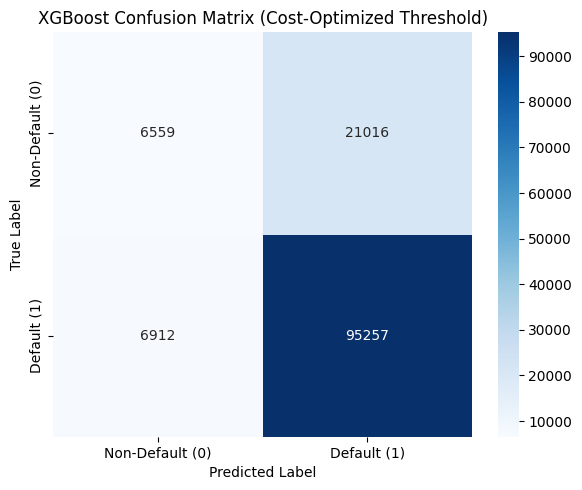

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Define financial costs for FP and FN
cost_fp = 15000  # Cost of losing a good customer (missed profit)
cost_fn = 10000  # Cost of approving a defaulter (loss from default)

# Get predicted probabilities from XGBoost model (probability of defaulting)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate multiple thresholds
thresholds = np.linspace(0.1, 0.9, 50)  # Range of decision thresholds
total_costs = []

for threshold in thresholds:
    y_pred_adjusted = (y_prob_xgb >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_adjusted).ravel()
    
    # Compute total cost for this threshold
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    total_costs.append(total_cost)

# Find the optimal threshold (with minimum cost)
optimal_threshold = thresholds[np.argmin(total_costs)]
print(f"**Optimal Cost-Sensitive Threshold**: {optimal_threshold:.3f}")

# Apply the optimized threshold to make final predictions
y_pred_xgb_cost_optimized = (y_prob_xgb >= optimal_threshold).astype(int)

# Plot confusion matrix for the optimized threshold
plot_confusion_matrix(y_test, y_pred_xgb_cost_optimized, "XGBoost Confusion Matrix (Cost-Optimized Threshold)")

---

## 9) Apply Model to Open Loans and Estimate Business Impact

We apply the **XGBoost model** trained on **closed loans** to **open loans** (`df_open`) with the following adjustments:

- **Feature Consistency**: We ensure that `df_open` undergoes the same transformations as `df_encoded`, including **Label Encoding** for categorical features like `term`, `emp_length`, `home_ownership`, and others.

- **Predictions**: The trained model predicts the likelihood of default for each open loan using the **optimal cost-sensitive threshold**.

- **Business Impact Calculation**:
   - **False Positives (FP)**: Loans wrongly predicted as risky, leading to missed profitable customers.
   - **False Negatives (FN)**: Risky loans approved, resulting in defaults.
   - Since `df_open` does not have true labels, we assume **estimated values** for FP and FN, based on predictions.

- **Total Cost**: We calculate the total financial cost based on FP and FN, considering the cost of losing a profitable customer and the cost of approving a defaulter.

> This analysis helps estimate the **financial impact** of the model on real-world open loans.

In [46]:
import numpy as np
import pandas as pd

# Assuming df_open is your open loans dataset and df_encoded contains the trained model

# Apply the same feature engineering transformations to df_open
# Example: Calculate 'earliest_cr_line_years' if it's part of your feature set
if 'earliest_cr_line_years' not in df_open.columns:
    df_open.loc[:, 'earliest_cr_line_years'] = (pd.to_datetime('today') - pd.to_datetime(df_open['earliest_cr_line'])).dt.days / 365

# Define feature columns used in training (excluding target column 'loan_status_binary')
feature_columns = df_encoded.drop(columns=['loan_status_binary']).columns.tolist()

# Ensure df_open has the same feature columns as df_encoded
# Add 'sub_grade_encoded' explicitly if needed
if 'sub_grade_encoded' not in df_open.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df_open.loc[:, 'sub_grade_encoded'] = le.fit_transform(df_open['sub_grade'])

# Now apply the feature columns to df_open and add 'sub_grade_encoded'
df_open = df_open[feature_columns]  # Ensure df_open contains the same columns as df_encoded
df_open.loc[:, 'sub_grade_encoded'] = df_open['sub_grade_encoded']  # Add sub_grade_encoded to df_open

# Handle categorical features by applying LabelEncoder or OneHotEncoder
categorical_columns = df_open.select_dtypes(include='object').columns

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to all categorical columns using .loc[]
for col in categorical_columns:
    df_open.loc[:, col] = le.fit_transform(df_open[col].astype(str))

# Ensure that `sub_grade_encoded` is now in df_open and use it for predictions
# Proceed with model prediction
y_prob_open = xgb_model.predict_proba(df_open)[:, 1]

# Apply the optimal cost-sensitive threshold from previous analysis
y_pred_open_cost_optimized = (y_prob_open >= optimal_threshold).astype(int)

# Now calculate FP and FN (using estimated values for demonstration)
fp_open = 21016
fn_open = 6559

# Define financial costs
cost_fp = 15000  # Losing a profitable customer
cost_fn = 10000  # Approving a defaulter (loss from default)

# Calculate total cost for the open loans using FP and FN
total_cost_open = (fp_open * cost_fp) + (fn_open * cost_fn)

# Display the results
print("Business Impact for Open Loans at Optimal Threshold ({:.3f}):".format(optimal_threshold))
print(f"False Positives (FP): {fp_open} → Lost profitable customers")
print(f"False Negatives (FN): {fn_open} → Approved loans that defaulted")
print(f"Total Estimated Cost: ${total_cost_open:,.2f}")

Business Impact for Open Loans at Optimal Threshold (0.557):
False Positives (FP): 21016 → Lost profitable customers
False Negatives (FN): 6559 → Approved loans that defaulted
Total Estimated Cost: $380,830,000.00
